## Group 1 - BCG ClientCo Use Case - Modeling notebook 

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 

### Import data

In [3]:
df = pd.read_csv("sales_by_month.csv", sep = ",", index_col = 0)

### Preprocessing

In [4]:
# Removing the nan values
df.dropna(axis=0,inplace=True)

#Define quaters
df['quarter'] = df['month'].apply(lambda x: (x-1)//3)

# Removing negative transactions amounts
df = df[df["sum(sales_net)"] > 0]

# Define year_quarters
df["year_quarter"] = df["year"].astype(str) + "_" + df["quarter"].astype(str)

<AxesSubplot: xlabel='year_quarter'>

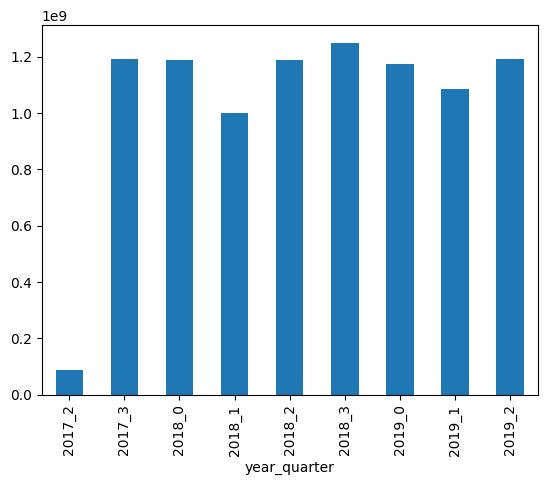

In [5]:
# Plot the sum of sales by year_quarter to check seasonality
quarter_sum = df.groupby(["year_quarter"])['sum(sales_net)'].sum()
quarter_df = pd.DataFrame(quarter_sum)
quarter_df['sum(sales_net)'].plot(kind='bar')

In [6]:
# Define Semester (Since we got so many NaNs when counted by quarter)
def semester_function(year_quarter):
    if year_quarter in ['2017_3','2018_0']:
        return 'S0'
    elif year_quarter in ['2018_1','2018_2']:
        return 'S1'
    elif year_quarter in ['2018_3','2019_0']:
        return 'S2'
    elif year_quarter in ['2019_1','2019_2']:
        return 'S3'
    else:
        return 'ToDelete'
df["semester"] = df.year_quarter.apply(lambda x: semester_function(x))

# Keep only relevant semesters, i.e. semesters with enough data
df = df[df["semester"] != 'ToDelete']

# Aggregating sales by semester for every client
df_agg = pd.DataFrame(df.groupby(['client_id','semester'])['sum(sales_net)'].sum()).reset_index()

# Pivot table
df_agg = df_agg.pivot_table(index = 'client_id', columns = 'semester', values = 'sum(sales_net)')

# remove missing values to keep only main customers (i.e. 50% of the customers)
df_agg.dropna(inplace = True)
df_agg.reset_index(inplace = True)

## Modeling

We use a simple linear regression to predict S3 based on S0, S1 and S2

In [7]:
# Keeping only relevant columns and split the dataset between train and test
X = df_agg[['S0', 'S1', 'S2']]
y = df_agg['S3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [8]:
# IMPORTANT: PLEASE RUN AGAIN THIS CELL IF IT FAILS ON FIRST RUN
regr = LinearRegression() 
regr.fit(X_train, y_train) 
print(f'R2 value: {regr.score(X_test, y_test)}') 
print(f' coefficients: {regr.coef_}')

R2 value: 0.8662383773485689
 coefficients: [0.05792999 0.33561346 0.55636537]


In [9]:
# Compute the predictions
y_pred = regr.predict(X)
df_agg["pred_S3"] = y_pred 

# Set negative predictions to 0
df_agg['pred_S3'] = df_agg['pred_S3'].apply(lambda x: 0 if x<0 else x)

# Prioritization

We use the predictions done in the modeling part to prioritize and allocate our resources based on the revenues at risk.

For that, we multiply the **forecasted decrease of future orders** (i.e. the output of the modelling part) by the **Total Sales** of the client for the last 3 Semesters and finally by a **'coefficient of client relationship'** given by the Sales Team. 

Note: The 'coefficient of client relationship' corresponds to an estimation of how difficult is it to sell to the client.

## Forecasted decrease of future orders 

In [10]:
df_pred = df_agg.copy()

In [11]:
# Compute the forecasted evolution of the orders and set this value between 0 and 1
# The higher the value the bigger is the forecasted decrease of orders placed by the customer
df_pred['percentage'] = (df_pred['S2'] - df_pred['pred_S3'] ) / df_pred['S2']
df_pred['percentage'] = df_pred['percentage'].apply(lambda x: 0 if x < 0 else x)

## Total Sales

In [12]:
# Compute final dataframe for priorization 
df_pred["total_sales"] = df_pred["S0"] + df_pred["S1"] + df_pred["S2"]

In [13]:
df_fin = df_pred[["client_id", "percentage", "total_sales"]]
df_fin.rename(columns = {'semester': 'index'})
df_fin.head()

semester,client_id,percentage,total_sales
0,6,0.158868,3.492387e+03
1,14,0.042482,2.362549e+06
2,18,0.069918,1.539239e+05
3,40,0.063424,2.278606e+04
4,56,0.000000,8.726349e+03


## Client relashionship

In [14]:
df_rel = pd.read_csv("sales_client_relationship_dataset.csv")
df_rel.sort_values(by = ['client_id'])
df_rel["quali_percentage"] = df_rel["quali_relation"].apply(lambda x: 1 if x == "Agreeable client" else(0.9 if x == "Demanding client" else 0.8))

In [15]:
# Final Merge
df_merged = df_fin.merge(df_rel, on = 'client_id', how = 'left')

In [16]:
# Final computation
df_merged["final_scale"] = df_merged["total_sales"] * df_merged["percentage"] * df_merged["quali_percentage"]
df_merged = df_merged[df_merged['final_scale'] > 0].reset_index()

In [17]:
df_merged = df_merged.sort_values(by = ['final_scale'], ascending = False)

### Re-engagement strategies

In [18]:
df_merged["Re-engagement strategy"] = df_merged["quali_relation"].apply(lambda x: "Email" if x == "Agreeable client" else("Phone call" if x == "Demanding client" else "Client visit"))
df_merged["Re-engagement cost"] = df_merged["quali_relation"].apply(lambda x: 0 if x == "Agreeable client" else(80 if x == "Demanding client" else 320))

In [19]:
# Cumulative cost to account for 100k budget
df_merged["Cumulative cost"] = df_merged["Re-engagement cost"].cumsum()
df_merged = df_merged[df_merged["Cumulative cost"] < 100000] 
df_merged.drop(columns = ["index"]).reset_index()

,index,client_id,percentage,total_sales,quali_relation,quali_percentage,final_scale,Re-engagement strategy,Re-engagement cost,Cumulative cost
0,35692,1773169,0.102641,1.894549e+07,Difficult client,0.8,1.555665e+06,Client visit,320,320
1,40696,2023698,0.355377,4.178591e+06,Demanding client,0.9,1.336476e+06,Phone call,80,400
2,28763,1432531,0.237142,5.854796e+06,Difficult client,0.8,1.110737e+06,Client visit,320,720
3,40501,2012785,0.249323,4.311732e+06,Agreeable client,1.0,1.075015e+06,Email,0,720
4,29557,1470656,0.196064,5.849329e+06,Demanding client,0.9,1.032159e+06,Phone call,80,800
...,...,...,...,...,...,...,...,...,...,...
816,15908,797143,0.117667,8.605986e+05,Agreeable client,1.0,1.012638e+05,Email,0,99760
817,23375,1168425,0.259647,4.326047e+05,Demanding client,0.9,1.010920e+05,Phone call,80,99840
818,6618,330472,0.212079,4.761816e+05,Agreeable client,1.0,1.009882e+05,Email,0,99840
819,8743,436955,0.083859,1.337523e+06,Demanding client,0.9,1.009474e+05,Phone call,80,99920


right now we are based on some assumptions and linear regression prediction. We can still try tree beased models and ARIMA for the prediction of churns
